In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.plots import *

from fastprogress import master_bar, progress_bar

from matplotlib import patches, patheffects

from pathlib import Path

from skimage.io import imread
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops

from scipy import ndimage

import cv2

cuda.set_device(0)

C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Stage 1 Dataset

In [3]:
PATH = Path('data')
TMP_PATH = "tmp/tmp"
MODEL_PATH = "tmp/model/"
sz = 128
arch = resnet34
bs = 128

In [4]:
train_masks_fn = f'{PATH}/train_ship_segmentations_v2.csv'
train_masks_path = Path(PATH/'train_ship_segmentations_v2.csv')

images_path = Path(PATH/'train_v2')

masks_path = Path(PATH/'train_masks_sampled')

images_test_path = Path(PATH/'test_v2')

masks_test_path = Path(PATH/'test_masks')

In [5]:
masks = pd.read_csv(train_masks_fn)
masks.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [6]:
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

In [7]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [ ]:
first_image = '000155de5.jpg'

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
rle_0 = masks.query(f'ImageId=="{first_image}"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0[:, :, 0])
ax1.set_title('Image$_0$')
rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1[:, :, 0])
ax2.set_title('Image$_1$')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))
show_img(Image.open(images_path/'000155de5.jpg'), ax=ax3)

In [ ]:
images_with_ship = masks.ImageId[masks.EncodedPixels.isnull()==False]
images_with_ship = np.unique(images_with_ship.values)
print('There are ' +str(len(images_with_ship)) + ' image files with masks')

## Undersampling the empty masks (only needed once)

In [ ]:
grouped_masks = masks.groupby('ImageId', as_index=False).count()

In [ ]:
len(grouped_masks[grouped_masks.EncodedPixels==0]), len(grouped_masks[grouped_masks.EncodedPixels>0])

In [ ]:
empty_masks = grouped_masks[grouped_masks.EncodedPixels==0]

In [ ]:
undersampled_masks = empty_masks.ImageId.sample(n=len(grouped_masks[grouped_masks.EncodedPixels>0]))

In [ ]:
sample_ids = undersampled_masks.append(grouped_masks[grouped_masks.EncodedPixels>0].ImageId)

In [ ]:
sampled_masks = masks.set_index('ImageId').loc[sample_ids]

In [ ]:
sampled_masks.reset_index(inplace=True)

In [ ]:
len(sampled_masks['ImageId'].unique()), len(sampled_masks[sampled_masks.EncodedPixels.isnull()]['ImageId'].unique())

In [ ]:
'''# this is for converting the masks to images
#%%time
for image_id in sampled_masks.ImageId.unique():
    rle_0 = sampled_masks.query(f'ImageId=="{image_id}"')['EncodedPixels']
    img_0 = masks_as_image(rle_0)
    
    rle_1 = multi_rle_encode(img_0)
    img_1 = masks_as_image(rle_1)
    
    cv2.imwrite(f'data/train_masks_sampled/mask_{image_id}', img_1[:, :, 0]*255)'''

## When undersampling is done:

In [8]:
sampled_images = [w[5:] for w in os.listdir(masks_path)]

In [9]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

## Splitting into training and validation set

In [10]:
x_names = np.array([Path(images_path/f'{image_id}') for image_id in sampled_images])#[:200]
y_names = np.array([Path(masks_path/f'{mask_id}') for mask_id in os.listdir(masks_path)])#[:200]
x_test_names = np.array([Path(images_test_path/f'{image_id}') for image_id in os.listdir(images_test_path)])
y_test_names = np.array([Path(images_test_path/f'{mask_id}') for mask_id in os.listdir(images_test_path)])

In [11]:
val_idxs = get_cv_idxs(len(x_names))
len(x_names), len(val_idxs)

(89225, 17845)

In [12]:
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

## Transformations

In [13]:
aug_tfms = [RandomRotate(10, tfm_y=TfmType.CLASS),
            RandomDihedral(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05)]

## Unet (ish)

In [14]:
f = resnet34
cut,lr_cut = model_meta[f]

In [15]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [16]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [17]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [18]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [19]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

## Feeding everything into pytorch using fastai

In [ ]:
tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, test=(x_test_names, y_test_names), path='')
data = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [ ]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.aug_dl))
x = denorm(x)

In [ ]:
fig, axes = plt.subplots(5, 6, figsize=(12, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

## Create model and fitting for size 128

In [ ]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [ ]:
def iou(preds, targs):
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
    n = targs.shape[0]
    preds = preds.view(n,-1)
    targs = targs.view(n,-1)
    intersect = (preds*targs).sum().float()
    union = (preds+targs).sum().float()
    return intersect / (union-intersect+1.0)

In [ ]:
learn = ConvLearner(data, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5), iou]

In [ ]:
learn.summary()

In [ ]:
learn.freeze_to(1)

In [ ]:
learn.lr_find()
learn.sched.plot()

In [ ]:
lr=4e-3
wd=1e-8

lrs = np.array([lr/9,lr/3,lr])

In [ ]:
learn.fit(lr,1,wds=wd,cycle_len=6,use_clr=(4, 6), best_save_name='unet_128_xe_best')

In [ ]:
learn.save('unet_128_6e')

In [ ]:
learn.fit(lr,1,wds=wd,cycle_len=10,use_clr=(4, 5), best_save_name='unet_128_xe_best')

In [ ]:
learn.save('unet_128_16e')

In [ ]:
learn.unfreeze()

In [ ]:
lrs = np.array([lr/9,lr/3,lr])

In [ ]:
learn.fit(lrs,1,cycle_len=5,use_clr=(20,5))

In [ ]:
learn.save('unet_128_5e_unfrozen')

In [ ]:
learn.fit(lrs,1,cycle_len=8,use_clr=(20,5))

In [ ]:
learn.save('unet_128_13e_unfrozen')

## evaluation with trained resnet layers size 128

In [ ]:
x,y = next(iter(data.test_dl))
py = to_np(learn.model(V(x)))

#x,y = next(iter(data.val_dl))
#py = to_np(learn.model(V(x)))

In [ ]:
for i in range(0, 63):
    if len(py[i][py[i]>0]):
        print(i)

In [ ]:
idx = 50

In [ ]:
ax = show_img(denorm(x)[idx])
show_img(y[idx], ax=ax, alpha=0.5);

In [ ]:
ax = show_img(denorm(x)[idx])
show_img(py[idx]>0, ax=ax, alpha=0.5);

## size 256

In [ ]:
bs = 32
sz = 256

In [ ]:
tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, test=(x_test_names, y_test_names), path='')
data = ImageData(PATH, datasets, bs, num_workers=4, classes=None)

In [ ]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.aug_dl))
x = denorm(x)

In [ ]:
fig, axes = plt.subplots(5, 6, figsize=(12, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [ ]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [ ]:
learn = ConvLearner(data, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5), IoU]

In [ ]:
learn.freeze_to(1)

In [ ]:
learn.lr_find(start_lr=1e-8)
learn.sched.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit(lr,1,cycle_len=3,use_clr=(20,5))

In [ ]:
learn.save('unet_256_3e')

In [ ]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

In [ ]:
learn.save('unet_256_8e')

In [ ]:
learn.load('unet_256_8e')

In [ ]:
learn.unfreeze()

In [ ]:
lrs = np.array([lr/9,lr/3,lr])

In [ ]:
learn.fit(lrs,1,cycle_len=3,use_clr=(20,5))

In [ ]:
learn.save('unet_256_3e_unfrozen')

In [ ]:
learn.fit(lrs,1,cycle_len=5,use_clr=(20,5))

In [ ]:
learn.save('unet_256_8e_unfrozen')

## evaluation with trained resnet layers size 256

In [ ]:
x,y = next(iter(data.test_dl))
py = to_np(learn.model(V(x)))

#x,y = next(iter(data.val_dl))
#py = to_np(learn.model(V(x)))

In [ ]:
for i in range(0, 31):
    if len(py[i][py[i]>0]):
        print(i)

In [ ]:
idx = 10

In [ ]:
ax = show_img(denorm(x)[idx])
show_img(y[idx], ax=ax, alpha=0.5);

In [ ]:
ax = show_img(denorm(x)[idx])
show_img(py[idx]>0, ax=ax, alpha=1);

## size 512

In [ ]:
bs = 11
sz = 512

In [ ]:
tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, test=(x_test_names, y_test_names), path='')
data = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [ ]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.aug_dl))
x = denorm(x)

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(12, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [ ]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [ ]:
learn = ConvLearner(data, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5), IoU]

In [ ]:
learn.load('unet_256_8e_unfrozen')

In [ ]:
learn.freeze_to(1)

In [ ]:
learn.lr_find(start_lr=1e-8)
learn.sched.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit(lr,1,cycle_len=3,use_clr=(20,5))

In [ ]:
learn.save('unet_512_3e')

In [ ]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

In [ ]:
learn.save('unet_512_8e')

In [ ]:
learn.load('unet_512_8e')

In [ ]:
learn.unfreeze()

In [ ]:
lrs = np.array([lr/9,lr/3,lr])

In [ ]:
learn.fit(lrs,1,cycle_len=3,use_clr=(20,5))

In [ ]:
learn.save('unet_512_3e_unfrozen')

In [ ]:
learn.load('unet_512_3e_unfrozen')

In [ ]:
#learn.summary()
#learn.get_layer_groups

In [ ]:
learn.fit(lrs,1,cycle_len=5,use_clr=(20,5))

In [ ]:
learn.save('unet_512_8e_unfrozen')

## evaluation with trained resnet layers size 512

In [ ]:
learn.model.eval()

In [ ]:
x,y = next(iter(data.test_dl))
py = to_np(learn.model(V(x)))

#x,y = next(iter(data.val_dl))
#py = to_np(learn.model(V(x)))

In [ ]:
py.shape

In [ ]:
for i in range(0, 11):
    if len(py[i][py[i]>0]):
        print(i)

In [ ]:
idx = 10

In [ ]:
ax = show_img(denorm(x)[idx])
show_img(y[idx], ax=ax, alpha=0.5);

In [ ]:
ax = show_img(denorm(x)[idx])
show_img(py[idx]>0, ax=ax, alpha=0.5);

## size 768

In [20]:
bs = 6
sz = 768

In [21]:
tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, test=(x_test_names, y_test_names), path='')
data = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [22]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.aug_dl))
x = denorm(x)

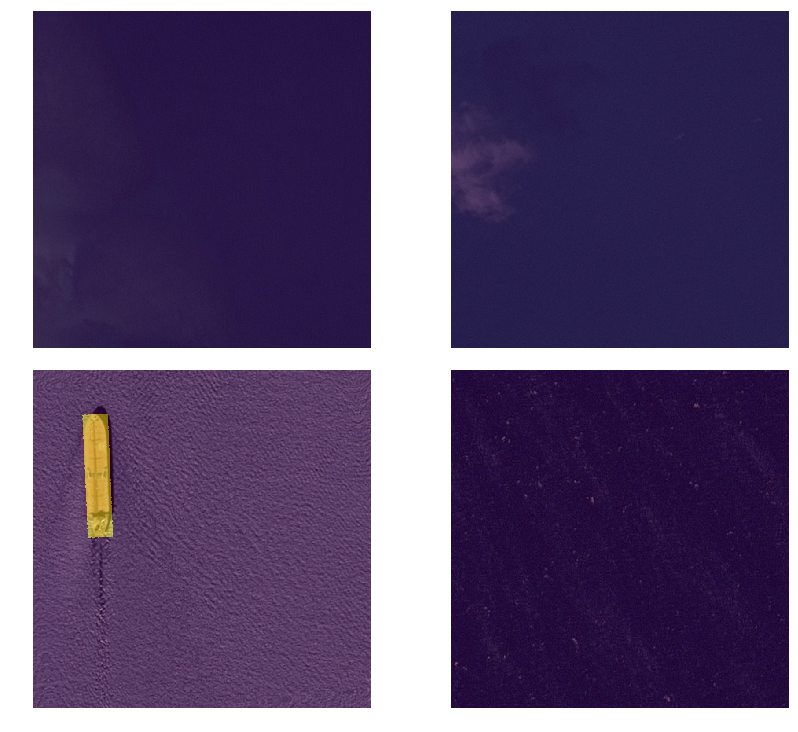

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [24]:
'''def IoU(pred, targs):
    pred = (pred > 0).astype(float)
    intersection = (pred*targs).sum()
    return intersection / ((pred+targs).sum() - intersection + 1.0)

def iou(input, targs):
    "IoU coefficient metric for binary target."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input*targs).sum().float()
    union = (input+targs).sum().float()
    return intersect / (union-intersect+1.0)
'''

'def IoU(pred, targs):\n    pred = (pred > 0).astype(float)\n    intersection = (pred*targs).sum()\n    return intersection / ((pred+targs).sum() - intersection + 1.0)\n\ndef iou(input, targs):\n    "IoU coefficient metric for binary target."\n    n = targs.shape[0]\n    input = input.argmax(dim=1).view(n,-1)\n    targs = targs.view(n,-1)\n    intersect = (input*targs).sum().float()\n    union = (input+targs).sum().float()\n    return intersect / (union-intersect+1.0)\n'

In [25]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [26]:
learn = ConvLearner(data, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5)]

In [ ]:
learn.freeze_to(1)

In [ ]:
learn.lr_find(start_lr=1e-8)
learn.sched.plot()

In [27]:
lr=4e-3
wd=1e-8

lrs = np.array([lr/9,lr/3,lr])

In [ ]:
learn.fit(lr,1,wds=wd,cycle_len=4,use_clr=(4, 4), best_save_name='unet_768_xe_best')

In [ ]:
learn.save('unet_128_4e')

In [28]:
learn.load('unet_768_xe_best')

In [29]:
learn.unfreeze()

In [ ]:
learn.fit(lrs,1,wds=wd,cycle_len=6,use_clr=(4, 3), best_save_name='unet_768_xe_best_unfrozen')

In [ ]:
learn.save('unet_128_6e_unfrozen')

## evaluation with trained resnet layers size 768

In [ ]:
learn.load('unet_768_3e_unfrozen')

In [ ]:
learn.model.eval()

In [ ]:
x,y = next(iter(data.test_dl))
py = to_np(learn.model(V(x)))

#x,y = next(iter(data.val_dl))
#py = to_np(learn.model(V(x)))

In [ ]:
py.shape

In [ ]:
for i in range(0, 8):
    if len(py[i][py[i]>0]):
        print(i)

In [ ]:
idx = 3

In [ ]:
ax = show_img(denorm(x)[idx])
show_img(y[idx], ax=ax, alpha=0.5);

In [ ]:
ax = show_img(denorm(x)[idx])
show_img(py[idx]>0, ax=ax, alpha=0.5);

In [ ]:
'''# TODO: refacter with this function

def get_learner(sz=128, bs=128):
    tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
    datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, test=(x_test_names, y_test_names), path='')
    data = ImageData(PATH, datasets, bs, num_workers=4, classes=None)
    
    models = ConvnetBuilder(arch, 0, 0, 0, custom_head=simple_up)
    learn = ConvLearner(data, models)
    learn.opt_fn=optim.Adam
    learn.crit=nn.BCEWithLogitsLoss()
    learn.metrics=[accuracy_thresh(0.5), IoU]

    return learn'''

### Prediction for each ship so we have to split (thanks Iafoss for these convenient functions!)

In [ ]:
def enc_test(yps, names):
    for i in range(len(yps)):
        if len(yps[i][yps[i]>0]) > 0:
            masks = split_mask(yps[i])
            if len(masks) == 0:
                print('no mask returned!')
                ship_list_dict.append({'ImageId':names[i],'EncodedPixels':''})
            for mask in masks:
                ship_list_dict.append({'ImageId':names[i],'EncodedPixels':rle_encode(mask)})
        else: 
            ship_list_dict.append({'ImageId':names[i],'EncodedPixels':''})

In [ ]:
def split_mask(mask):
    threshold = 0
    threshold_obj = 0 #ignore predictions composed of "threshold_obj" pixels or less
    labled,n_objs = ndimage.label(mask > threshold)
    result = []
    for i in range(n_objs):
        obj = (labled == i + 1).astype(int)
        #if(obj.sum() > threshold_obj): 
        result.append(obj)
    return result

## create submission

In [ ]:
learn.load('unet_768_3e_unfrozen')

In [ ]:
learn.model.eval()

In [ ]:
batch_length = int(math.ceil((len(data.test_ds)/bs)/30)) #split into 30 batches because of ram limitation

mb = master_bar(range(30))
mb.first_bar.comment = f'progress on test-set'

test_iter = iter(data.test_dl)

ship_list_dict = []
py = np.empty((0, 768, 768), float)

In [ ]:
'''try:
    for i in mb:
        for j in progress_bar(range(batch_length), parent=mb):
            x,y = next(test_iter)
            py = np.append(py, to_np(learn.model(V(x))), axis=0)
        f_names = data.test_ds.fnames[batch_length * bs * i:batch_length * bs * (i+1)]
        enc_test(py, f_names)
        py = np.empty((0, 768, 768), float)
except StopIteration:
    pass'''

In [ ]:
i = 0
while True:
    print(i)
    x,y = next(test_iter)
    py = np.append(py, to_np(learn.model(V(x))), axis=0)
    
    f_names = data.test_ds.fnames[i:i+bs]
    enc_test(py, f_names)
    py = np.empty((0, 768, 768), float)
    i += bs

In [ ]:
len(ship_list_dict)

In [ ]:
pred_df = pd.DataFrame(ship_list_dict)

In [ ]:
pred_df.ImageId.nunique()

In [ ]:
len(np.unique(data.test_ds.fnames)) - pred_df.ImageId.nunique()

In [ ]:
len(pred_df), len(pred_df.groupby('ImageId', axis=0))

In [ ]:
len(os.listdir(images_test_path))

In [ ]:
len(set(os.listdir(images_test_path)))

In [ ]:
len(set(pred_df.ImageId.astype(str)))

In [ ]:
len(set(os.listdir(images_test_path)).difference(set(data.test_ds.fnames)))

In [ ]:
pred_df.ImageId = pred_df.ImageId.apply(lambda x: str(x).split('\\')[-1])

In [ ]:
pred_df.to_csv('submission.csv',index=False)